# Biebrza Pixel Time-Series Classification with PyTorch

This notebook loads the exported **biannual pixel time-series** dataset from Google Drive
and trains two neural models to classify vegetation trajectory categories:

- A **1D Convolutional Network** (Conv1D)
- An **LSTM**

It then compares their performance.

Assumptions:
- This notebook loads a table from Google Earth Engine named
  `biebrza_biannual_pixel_series.csv` from the folder `GEE_Biebrza` in Drive.
- Each row is one pixel, with columns:
  - `NDMI_YYYY_YYYY`, `NBR_YYYY_YYYY`, `NIR_YYYY_YYYY` for multiple 2-year windows
  - `traj_simpl` (original category label)
  - `numark` (square id)
  - `pixel_id` (unique pixel id)
  - `cat_id` (original numeric label, can be ignored here)


In [1]:
!pip install -q torch torchvision torchaudio scikit-learn

import os
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import shuffle as sk_shuffle
from sklearn.preprocessing import LabelEncoder


## Load dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your exported CSV (adjust if needed)
data_path = '/content/drive/MyDrive/GEE_Biebrza/biebrza_biannual_pixel_series.csv'

df = pd.read_csv(data_path)
print('Data shape:', df.shape)
print('Columns:', df.columns.tolist()[:20], '...')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (142327, 36)
Columns: ['system:index', 'NBR_1997_1998', 'NBR_1999_2000', 'NBR_2001_2002', 'NBR_2003_2004', 'NBR_2005_2006', 'NBR_2007_2008', 'NBR_2009_2010', 'NBR_2011_2012', 'NBR_2013_2014', 'NBR_2015_2016', 'NDMI_1997_1998', 'NDMI_1999_2000', 'NDMI_2001_2002', 'NDMI_2003_2004', 'NDMI_2005_2006', 'NDMI_2007_2008', 'NDMI_2009_2010', 'NDMI_2011_2012', 'NDMI_2013_2014'] ...


Quick look at the main label columns and one row:


In [3]:
print(df[['traj_simpl', 'numark']].head())
print('\nUnique traj_simpl values:', df['traj_simpl'].unique())
print('\nNumber of unique numark values (squares from Kopeć and Sławik (2020)):', len(df['numark'].unique()))


      traj_simpl numark
0  stable_shrubs    P84
1  stable_shrubs    P84
2  stable_shrubs    P84
3  stable_shrubs    P84
4  stable_shrubs    P84

Unique traj_simpl values: ['stable_shrubs' 'stable_trees' 'stable_wetland' 'wetland_to_shrubs'
 'shrubs_to_trees' 'wetland_to_trees']

Number of unique numark values (squares from Kopeć and Sławik (2020)): 13855


## Re-label categories and subsample pixels

Steps:
1. Merge `wetland_to_trees` into `wetland_to_shrubs` → new class `wetland_to_woody`.
2. Keep only these classes:
   - `wetland_to_woody` (all pixels)
   - `shrubs_to_trees` (all pixels)
   - `stable_wetland` (max 5000 pixels)
   - `stable_trees` (max 5000 pixels)
   - `stable_shrubs` (max 5000 pixels)
3. Drop all other categories.
4. Compute **class weights** based on the full dataset size (before subsampling)
   for use in the loss function.


In [4]:
# 2.1 Create unified class string column

df['class_str'] = df['traj_simpl']

# Merge wetland_to_* into wetland_to_woody
df.loc[df['class_str'].isin(['wetland_to_shrubs', 'wetland_to_trees']), 'class_str'] = 'wetland_to_woody'

print('New unique class_str values:', df['class_str'].unique())

# 2.2 Keep only desired classes
target_classes = ['wetland_to_woody', 'shrubs_to_trees', 'stable_wetland', 'stable_trees', 'stable_shrubs']

df = df[df['class_str'].isin(target_classes)].copy()
print('After filtering, shape:', df.shape)
print('Class counts (all pixels, before subsampling):')
print(df['class_str'].value_counts())

# 2.3 Compute class weights based on FULL filtered dataset size
class_counts_full = df['class_str'].value_counts().to_dict()
num_classes = len(target_classes)
total_samples_full = len(df)

class_weights_dict = {}
for cls in target_classes:
    count_c = class_counts_full.get(cls, 1)
    # Inverse-frequency style weight
    class_weights_dict[cls] = total_samples_full / (num_classes * count_c)

print('\nClass weights (for loss):')
for k, v in class_weights_dict.items():
    print(f'  {k}: {v:.3f}')

# 2.4 Subsample per class (where requested)
samples_per_class = {
    'wetland_to_woody': None,   # all
    'shrubs_to_trees': None,   # all
    'stable_wetland': 5000,
    'stable_trees': 5000,
    'stable_shrubs': 5000,
}

dfs = []
rng = np.random.default_rng(42)

for cls in target_classes:
    df_cls = df[df['class_str'] == cls]
    n = len(df_cls)
    max_n = samples_per_class[cls]
    if max_n is None or n <= max_n:
        dfs.append(df_cls)
        print(f'Class {cls}: using ALL {n} pixels')
    else:
        df_sampled = df_cls.sample(n=max_n, random_state=42)
        dfs.append(df_sampled)
        print(f'Class {cls}: downsampled from {n} to {max_n} pixels')

df_balanced = pd.concat(dfs, ignore_index=True)
df_balanced = sk_shuffle(df_balanced, random_state=42)

print('\nAfter balancing, per-class counts:')
print(df_balanced['class_str'].value_counts())


New unique class_str values: ['stable_shrubs' 'stable_trees' 'stable_wetland' 'wetland_to_woody'
 'shrubs_to_trees']
After filtering, shape: (142327, 37)
Class counts (all pixels, before subsampling):
class_str
stable_wetland      71229
stable_trees        45845
stable_shrubs       18990
shrubs_to_trees      4584
wetland_to_woody     1679
Name: count, dtype: int64

Class weights (for loss):
  wetland_to_woody: 16.954
  shrubs_to_trees: 6.210
  stable_wetland: 0.400
  stable_trees: 0.621
  stable_shrubs: 1.499
Class wetland_to_woody: using ALL 1679 pixels
Class shrubs_to_trees: using ALL 4584 pixels
Class stable_wetland: downsampled from 71229 to 5000 pixels
Class stable_trees: downsampled from 45845 to 5000 pixels
Class stable_shrubs: downsampled from 18990 to 5000 pixels

After balancing, per-class counts:
class_str
stable_trees        5000
stable_shrubs       5000
stable_wetland      5000
shrubs_to_trees     4584
wetland_to_woody    1679
Name: count, dtype: int64


## Train/Val/Test split by square (`numark`) and class

Requirements:
- 60% train, 20% validation, 20% test.
- Stratified by **class_str**.
- All pixels from a given `numark` (square id) must go to the same split.

Implementation:
- For each class, collect unique `numark` values.
- Within each class, split its `numark`s into train/val/test sets by the 60/20/20 rule.
- Union over classes to get global sets of `numark` for each split.
  (Assumes each `numark` belongs predominantly to one class, as is typical for MPC squares.)


In [5]:
# 1. Stratified group split by class_str and numark

train_squares = set()
val_squares = set()
test_squares = set()

rng = np.random.default_rng(123)

for cls in target_classes:
    df_cls = df_balanced[df_balanced['class_str'] == cls]
    squares = df_cls['numark'].dropna().unique()
    squares = list(squares)
    rng.shuffle(squares)

    n = len(squares)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    # rest to test

    train_s = squares[:n_train]
    val_s = squares[n_train:n_train + n_val]
    test_s = squares[n_train + n_val:]

    train_squares.update(train_s)
    val_squares.update(val_s)
    test_squares.update(test_s)

print('Unique train squares:', len(train_squares))
print('Unique val squares  :', len(val_squares))
print('Unique test squares :', len(test_squares))

# 2. Build the actual splits
is_train = df_balanced['numark'].isin(train_squares)
is_val = df_balanced['numark'].isin(val_squares)
is_test = df_balanced['numark'].isin(test_squares)

df_train = df_balanced[is_train].copy()
df_val = df_balanced[is_val].copy()
df_test = df_balanced[is_test].copy()

print('\nSplit sizes (rows):')
print('Train:', df_train.shape[0])
print('Val  :', df_val.shape[0])
print('Test :', df_test.shape[0])

print('\nPer-class counts in Train:')
print(df_train['class_str'].value_counts())
print('\nPer-class counts in Val:')
print(df_val['class_str'].value_counts())
print('\nPer-class counts in Test:')
print(df_test['class_str'].value_counts())


Unique train squares: 5414
Unique val squares  : 1803
Unique test squares : 1809

Split sizes (rows):
Train: 12875
Val  : 4220
Test : 4168

Per-class counts in Train:
class_str
stable_wetland      3043
stable_trees        3029
stable_shrubs       3023
shrubs_to_trees     2773
wetland_to_woody    1007
Name: count, dtype: int64

Per-class counts in Val:
class_str
stable_trees        999
stable_shrubs       991
stable_wetland      985
shrubs_to_trees     908
wetland_to_woody    337
Name: count, dtype: int64

Per-class counts in Test:
class_str
stable_shrubs       986
stable_trees        972
stable_wetland      972
shrubs_to_trees     903
wetland_to_woody    335
Name: count, dtype: int64


## Build time-series tensors for PyTorch

We:
- Identify all NDMI/NBR/NIR band columns.
- Sort them by name to keep time order.
- Reshape features into `[N, T, C]` with `C=3` (NDMI, NBR, NIR).
- Encode `class_str` to integer labels 0..(num_classes-1).


In [6]:
# 1. Identify time-series columns (NDMI/NBR/NIR)

ts_cols = sorted([c for c in df_balanced.columns
                 if c.startswith('NDMI_') or c.startswith('NBR_') or c.startswith('NIR_')])

print('Number of time-series columns:', len(ts_cols))
print('First 9 time-series cols:', ts_cols[:9])

# 2. Determine sequence length (T) and feature channels (C=3)
T = len(ts_cols) // 3
assert len(ts_cols) == 3 * T, 'Expected number of time-series columns to be multiple of 3.'

print(f'Sequence length T = {T}, channels C = 3')

# 3. Label encoding

le = LabelEncoder()
le.fit(target_classes)  # ensure consistent class order

df_train['label_idx'] = le.transform(df_train['class_str'])
df_val['label_idx'] = le.transform(df_val['class_str'])
df_test['label_idx'] = le.transform(df_test['class_str'])

print('Label mapping:')
for cls, idx in zip(le.classes_, range(len(le.classes_))):
    print(f'  {cls} -> {idx}')

num_classes = len(le.classes_)

# 4. Class weights based on BALANCED dataset
class_counts_bal = df_balanced['class_str'].value_counts().to_dict()
total_bal = len(df_balanced)

class_weights_dict = {}
for cls in target_classes:
    count_c = class_counts_bal.get(cls, 1)
    class_weights_dict[cls] = total_bal / (num_classes * count_c)

# convert to tensor aligned with label_idx
class_weights_list = [class_weights_dict[cls] for cls in le.classes_]
class_weights = torch.tensor(class_weights_list, dtype=torch.float32)

print('\nClass weights tensor:', class_weights)

Number of time-series columns: 30
First 9 time-series cols: ['NBR_1997_1998', 'NBR_1999_2000', 'NBR_2001_2002', 'NBR_2003_2004', 'NBR_2005_2006', 'NBR_2007_2008', 'NBR_2009_2010', 'NBR_2011_2012', 'NBR_2013_2014']
Sequence length T = 10, channels C = 3
Label mapping:
  shrubs_to_trees -> 0
  stable_shrubs -> 1
  stable_trees -> 2
  stable_wetland -> 3
  wetland_to_woody -> 4

Class weights tensor: tensor([0.9277, 0.8505, 0.8505, 0.8505, 2.5328])


## Normalize values by training band-year mean

### Compute mean/std for each column separately

In [7]:

train_ts = df_train[ts_cols].astype(np.float32)

mean_per_col = train_ts.mean(axis=0)
std_per_col  = train_ts.std(axis=0) + 1e-6   # avoid 0 division

norm_stats = {
    'mean': mean_per_col,
    'std': std_per_col
}

print("Example stats:")
print(norm_stats['mean'][:5])
print(norm_stats['std'][:5])

Example stats:
NBR_1997_1998    0.265880
NBR_1999_2000    0.278889
NBR_2001_2002    0.313510
NBR_2003_2004    0.311265
NBR_2005_2006    0.305574
dtype: float32
NBR_1997_1998    0.048687
NBR_1999_2000    0.052665
NBR_2001_2002    0.050334
NBR_2003_2004    0.045025
NBR_2005_2006    0.050446
dtype: float32


### Normalize all splits using train stats

In [8]:
def normalize_df(df, mean_per_col, std_per_col, ts_cols):
    df_norm = df.copy()
    df_norm[ts_cols] = (df_norm[ts_cols] - mean_per_col) / std_per_col
    return df_norm

df_train_norm = normalize_df(df_train, mean_per_col, std_per_col, ts_cols)
df_val_norm   = normalize_df(df_val,   mean_per_col, std_per_col, ts_cols)
df_test_norm  = normalize_df(df_test,  mean_per_col, std_per_col, ts_cols)

## PyTorch Dataset and DataLoaders


In [9]:
class PixelTimeSeriesDataset(Dataset):
    def __init__(self, df, ts_cols, label_col):
        X = df[ts_cols].values.astype(np.float32)
        N = X.shape[0]
        T = len(ts_cols) // 3
        # reshape to [N, T, 3]
        X = X.reshape(N, T, 3)
        self.X = X
        self.y = df[label_col].values.astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = PixelTimeSeriesDataset(df_train_norm, ts_cols, 'label_idx')
val_ds   = PixelTimeSeriesDataset(df_val_norm,   ts_cols, 'label_idx')
test_ds  = PixelTimeSeriesDataset(df_test_norm,  ts_cols, 'label_idx')

batch_size = 256

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(12875, 4220, 4168)

## Define models: 1D-Conv and LSTM


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class Conv1DClassifier(nn.Module):
    def __init__(self, seq_len, num_classes):
        super().__init__()
        self.seq_len = seq_len
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)  # global average pooling over time
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, T, C]
        x = x.permute(0, 2, 1)  # [B, C, T]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # [B, 64]
        logits = self.fc(x)
        return logits


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [B, T, C]
        out, (h_n, c_n) = self.lstm(x)  # h_n: [num_layers, B, H]
        last_hidden = h_n[-1]           # [B, H]
        logits = self.fc(last_hidden)
        return logits


Using device: cuda


## Training and evaluation utilities


In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    return total_loss / total, correct / total


## Train Conv1D model


In [14]:
seq_len = T
conv_model = Conv1DClassifier(seq_len=seq_len, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-3)

num_epochs = 20

best_val_acc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(conv_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(conv_model, val_loader, criterion, device)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = conv_model.state_dict()

    print(f'Epoch {epoch:02d}: '
          f'train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, '
          f'val_loss={val_loss:.4f}, val_acc={val_acc:.3f}')

print('\nBest Conv1D val_acc:', best_val_acc)

if best_state is not None:
    conv_model.load_state_dict(best_state)

test_loss_conv, test_acc_conv = evaluate(conv_model, test_loader, criterion, device)
print(f'Conv1D TEST: loss={test_loss_conv:.4f}, acc={test_acc_conv:.3f}')


Epoch 01: train_loss=1.5545, train_acc=0.380, val_loss=1.4898, val_acc=0.444
Epoch 02: train_loss=1.3960, train_acc=0.493, val_loss=1.3171, val_acc=0.487
Epoch 03: train_loss=1.2407, train_acc=0.526, val_loss=1.2314, val_acc=0.493
Epoch 04: train_loss=1.1779, train_acc=0.524, val_loss=1.1984, val_acc=0.495
Epoch 05: train_loss=1.1491, train_acc=0.534, val_loss=1.1797, val_acc=0.522
Epoch 06: train_loss=1.1317, train_acc=0.543, val_loss=1.1684, val_acc=0.532
Epoch 07: train_loss=1.1189, train_acc=0.547, val_loss=1.1665, val_acc=0.525
Epoch 08: train_loss=1.1056, train_acc=0.554, val_loss=1.1481, val_acc=0.520
Epoch 09: train_loss=1.0943, train_acc=0.553, val_loss=1.1413, val_acc=0.535
Epoch 10: train_loss=1.0817, train_acc=0.563, val_loss=1.1401, val_acc=0.534
Epoch 11: train_loss=1.0738, train_acc=0.567, val_loss=1.1401, val_acc=0.550
Epoch 12: train_loss=1.0648, train_acc=0.568, val_loss=1.1252, val_acc=0.536
Epoch 13: train_loss=1.0587, train_acc=0.572, val_loss=1.1360, val_acc=0.530

9. Train LSTM model


In [15]:
lstm_model = LSTMClassifier(input_size=3, hidden_size=64, num_layers=1, num_classes=num_classes).to(device)

criterion_lstm = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

best_val_acc_lstm = 0.0
best_state_lstm = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(lstm_model, train_loader, criterion_lstm, optimizer_lstm, device)
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion_lstm, device)

    if val_acc > best_val_acc_lstm:
        best_val_acc_lstm = val_acc
        best_state_lstm = lstm_model.state_dict()

    print(f'Epoch {epoch:02d}: '
          f'train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, '
          f'val_loss={val_loss:.4f}, val_acc={val_acc:.3f}')

print('\nBest LSTM val_acc:', best_val_acc_lstm)

if best_state_lstm is not None:
    lstm_model.load_state_dict(best_state_lstm)

test_loss_lstm, test_acc_lstm = evaluate(lstm_model, test_loader, criterion_lstm, device)
print(f'LSTM TEST: loss={test_loss_lstm:.4f}, acc={test_acc_lstm:.3f}')


Epoch 01: train_loss=1.5417, train_acc=0.352, val_loss=1.4027, val_acc=0.421
Epoch 02: train_loss=1.2196, train_acc=0.511, val_loss=1.1555, val_acc=0.523
Epoch 03: train_loss=1.1206, train_acc=0.541, val_loss=1.1412, val_acc=0.530
Epoch 04: train_loss=1.0968, train_acc=0.555, val_loss=1.1185, val_acc=0.521
Epoch 05: train_loss=1.0757, train_acc=0.561, val_loss=1.1172, val_acc=0.539
Epoch 06: train_loss=1.0581, train_acc=0.571, val_loss=1.1025, val_acc=0.538
Epoch 07: train_loss=1.0442, train_acc=0.572, val_loss=1.0977, val_acc=0.554
Epoch 08: train_loss=1.0354, train_acc=0.575, val_loss=1.0865, val_acc=0.535
Epoch 09: train_loss=1.0234, train_acc=0.579, val_loss=1.0987, val_acc=0.532
Epoch 10: train_loss=1.0125, train_acc=0.583, val_loss=1.0970, val_acc=0.559
Epoch 11: train_loss=0.9996, train_acc=0.586, val_loss=1.0918, val_acc=0.560
Epoch 12: train_loss=0.9915, train_acc=0.591, val_loss=1.0780, val_acc=0.572
Epoch 13: train_loss=0.9849, train_acc=0.597, val_loss=1.0803, val_acc=0.565

10. Final comparison


In [16]:
print('\n=== Final Test Results ===')
print(f'Conv1D  - test_acc: {test_acc_conv:.3f}')
print(f'LSTM    - test_acc: {test_acc_lstm:.3f}')

print('\nClass mapping (label_idx -> class_str):')
for idx, cls in enumerate(le.classes_):
    print(f'  {idx}: {cls}')



=== Final Test Results ===
Conv1D  - test_acc: 0.594
LSTM    - test_acc: 0.610

Class mapping (label_idx -> class_str):
  0: shrubs_to_trees
  1: stable_shrubs
  2: stable_trees
  3: stable_wetland
  4: wetland_to_woody


### Benchmarking

In [13]:
print("Train class distribution:")
print(df_train['class_str'].value_counts(normalize=True))

print("\nTest class distribution:")
print(df_test['class_str'].value_counts(normalize=True))

Train class distribution:
class_str
stable_wetland      0.236350
stable_trees        0.235262
stable_shrubs       0.234796
shrubs_to_trees     0.215379
wetland_to_woody    0.078214
Name: proportion, dtype: float64

Test class distribution:
class_str
stable_shrubs       0.236564
stable_trees        0.233205
stable_wetland      0.233205
shrubs_to_trees     0.216651
wetland_to_woody    0.080374
Name: proportion, dtype: float64


In [14]:
print('X train shape:', train_ds.X.shape)  # expecting (N_train, T, 3)
print('Some min/max:', train_ds.X.min(), train_ds.X.max())


X train shape: (12875, 10, 3)
Some min/max: -0.103770554 26157.0


### Per-class performance

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def get_all_preds_labels(model, loader, device):
    model.eval()
    all_y = []
    all_pred = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            all_y.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return np.array(all_y), np.array(all_pred)

y_true, y_pred = get_all_preds_labels(lstm_model, test_loader, device)

print("Classification report (LSTM on TEST):")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Classification report (LSTM on TEST):
                  precision    recall  f1-score   support

 shrubs_to_trees       0.68      0.71      0.70       903
   stable_shrubs       0.50      0.28      0.36       986
    stable_trees       0.87      0.89      0.88       972
  stable_wetland       0.60      0.64      0.62       972
wetland_to_woody       0.21      0.42      0.28       335

        accuracy                           0.61      4168
       macro avg       0.58      0.59      0.57      4168
    weighted avg       0.63      0.61      0.61      4168



### Confusion matrix

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y_true, y_pred already computed earlier
# le.classes_ contains class names in correct index order
classes = le.classes_

# -------------------------------------------
# Build raw + normalized confusion matrices
# -------------------------------------------
cm = confusion_matrix(y_true, y_pred)             # raw counts
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # row-normalized

# -------------------------------------------
# Function to flatten matrix into sorted list
# -------------------------------------------
def sorted_confusion_pairs(cm, classes, normalized=False, top_n=None):
    rows = []
    n_classes = len(classes)

    for i in range(n_classes):
        for j in range(n_classes):
            value = cm[i, j]
            rows.append((classes[i], classes[j], value))

    # Sort by descending frequency
    rows_sorted = sorted(rows, key=lambda x: x[2], reverse=True)

    # Optionally show only top N pairs
    if top_n is not None:
        rows_sorted = rows_sorted[:top_n]

    # Pretty print
    print("\n===== Sorted Confusion Pairs ({}): =====".format(
        "normalized" if normalized else "raw counts"
    ))
    for true_label, pred_label, val in rows_sorted:
        if normalized:
            print(f"{true_label:<20} → {pred_label:<20} : {val:.4f}")
        else:
            print(f"{true_label:<20} → {pred_label:<20} : {val}")

    return rows_sorted

# -------------------------------------------
# Print sorted lists
# -------------------------------------------
sorted_raw   = sorted_confusion_pairs(cm,      classes, normalized=False)
sorted_norm  = sorted_confusion_pairs(cm_norm, classes, normalized=True)


===== Sorted Confusion Pairs (raw counts): =====
stable_trees         → stable_trees         : 867
shrubs_to_trees      → shrubs_to_trees      : 638
stable_wetland       → stable_wetland       : 618
stable_shrubs        → stable_wetland       : 289
stable_shrubs        → stable_shrubs        : 279
stable_shrubs        → wetland_to_woody     : 237
stable_wetland       → wetland_to_woody     : 175
stable_wetland       → stable_shrubs        : 159
stable_shrubs        → shrubs_to_trees      : 151
wetland_to_woody     → wetland_to_woody     : 142
shrubs_to_trees      → wetland_to_woody     : 99
stable_trees         → shrubs_to_trees      : 82
wetland_to_woody     → stable_wetland       : 74
shrubs_to_trees      → stable_trees         : 71
shrubs_to_trees      → stable_shrubs        : 55
wetland_to_woody     → stable_shrubs        : 49
wetland_to_woody     → shrubs_to_trees      : 46
shrubs_to_trees      → stable_wetland       : 40
stable_shrubs        → stable_trees         : 30
wetland_t

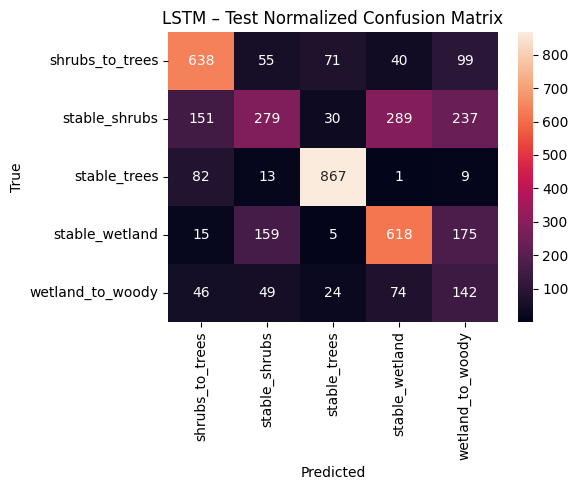

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('LSTM – Test Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

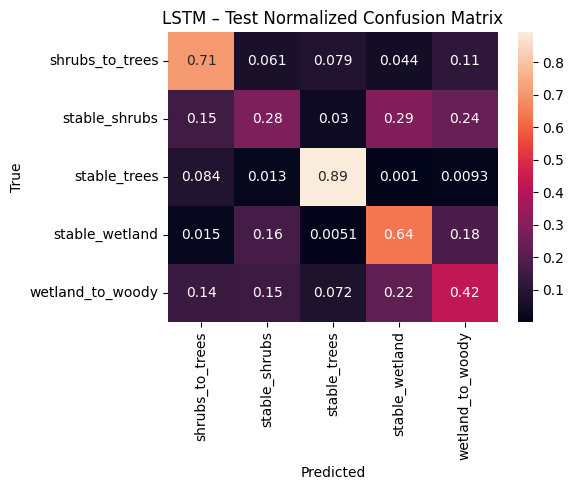

In [32]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # row-normalized

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('LSTM – Test Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

## Per-class distribution of indices and their time-series

Using columns:
  NDMI: NDMI_2015_2016
  NBR : NBR_2015_2016
  NIR : NIR_2015_2016


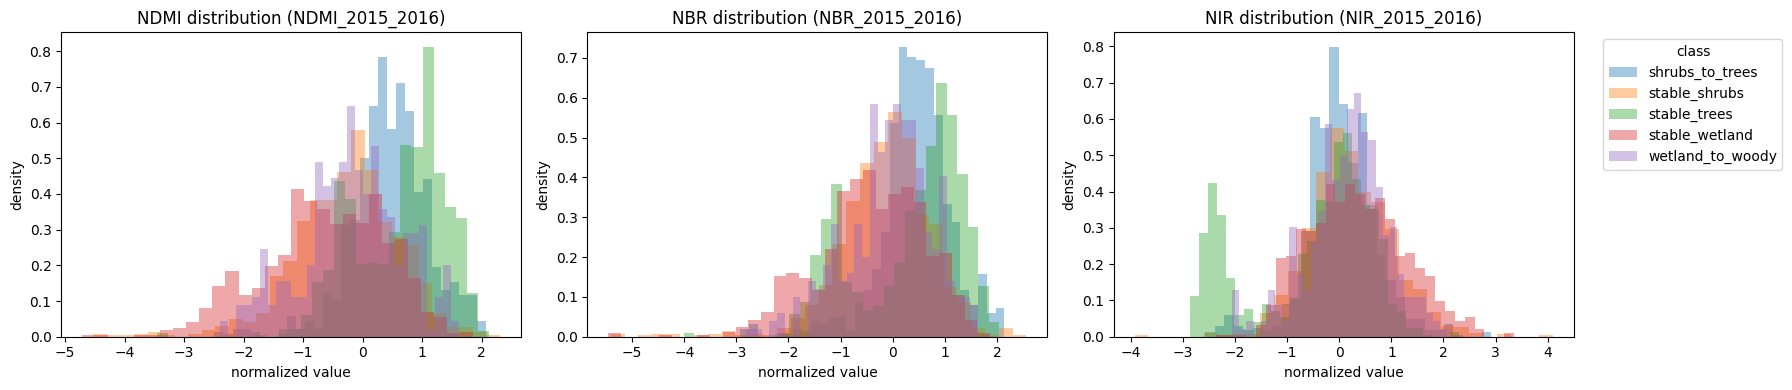

In [38]:
import matplotlib.pyplot as plt

# Identify the last NDMI, NBR, NIR columns (latest time step)
ndmi_cols = sorted([c for c in ts_cols if c.startswith('NDMI_')])
nbr_cols  = sorted([c for c in ts_cols if c.startswith('NBR_')])
nir_cols  = sorted([c for c in ts_cols if c.startswith('NIR_')])

last_ndmi_col = ndmi_cols[-1]
last_nbr_col  = nbr_cols[-1]
last_nir_col  = nir_cols[-1]

print("Using columns:")
print("  NDMI:", last_ndmi_col)
print("  NBR :", last_nbr_col)
print("  NIR :", last_nir_col)

classes = sorted(df_test_norm['class_str'].unique())

# Histograms per class for each index
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for cls in classes:
    subset = df_test_norm[df_test_norm['class_str'] == cls]
    axes[0].hist(subset[last_ndmi_col], bins=30, alpha=0.4, label=cls, density=True)
    axes[1].hist(subset[last_nbr_col],  bins=30, alpha=0.4, label=cls, density=True)
    axes[2].hist(subset[last_nir_col],  bins=30, alpha=0.4, label=cls, density=True)

axes[0].set_title(f'NDMI distribution ({last_ndmi_col})')
axes[1].set_title(f'NBR distribution ({last_nbr_col})')
axes[2].set_title(f'NIR distribution ({last_nir_col})')

for ax in axes:
    ax.set_xlabel('normalized value')
    ax.set_ylabel('density')

axes[2].legend(title='class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Average time series per class

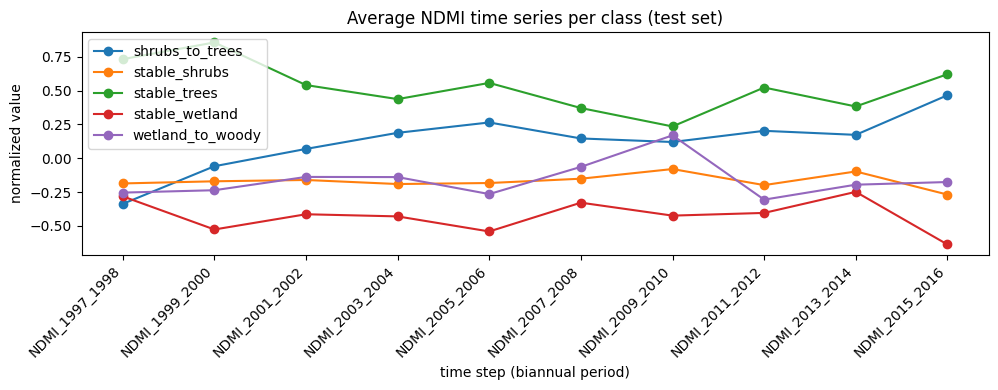

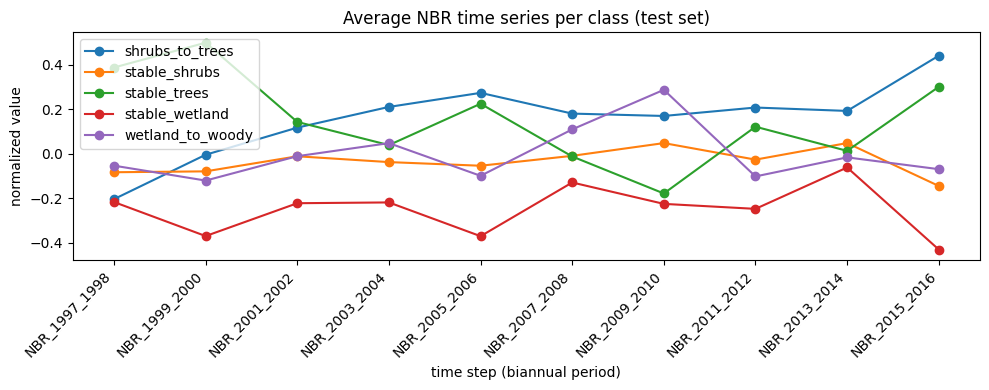

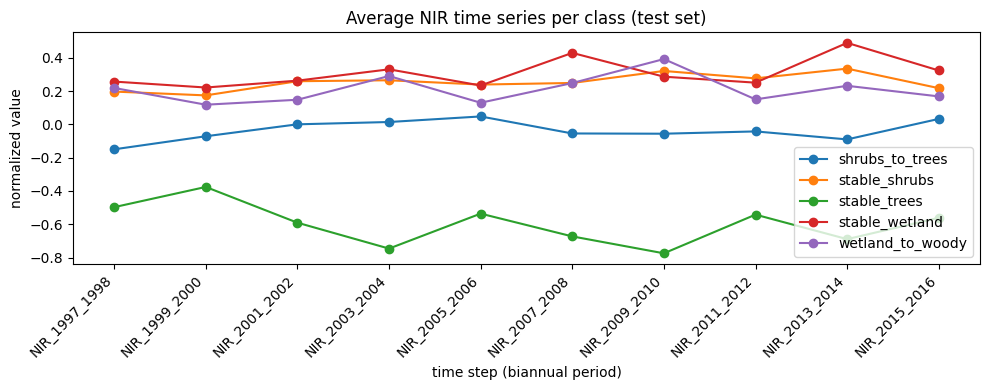

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Time labels for x-axis: use the NDMI_* column names
ndmi_cols = sorted([c for c in ts_cols if c.startswith('NDMI_')])
nbr_cols  = sorted([c for c in ts_cols if c.startswith('NBR_')])
nir_cols  = sorted([c for c in ts_cols if c.startswith('NIR_')])

T = len(ndmi_cols)
x = np.arange(T)
classes = sorted(df_test_norm['class_str'].unique())

# Helper to plot average series for a given set of columns
def plot_mean_series(df, cols, title):
    plt.figure(figsize=(10, 4))
    for cls in classes:
        subset = df[df['class_str'] == cls]
        mean_series = subset[cols].mean(axis=0).values
        plt.plot(x, mean_series, marker='o', label=cls)
    plt.xticks(x, cols, rotation=45, ha='right')
    plt.xlabel('time step (biannual period)')
    plt.ylabel('normalized value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Average NDMI over time per class
plot_mean_series(df_test_norm, ndmi_cols, 'Average NDMI time series per class (test set)')

# Average NBR over time per class
plot_mean_series(df_test_norm, nbr_cols, 'Average NBR time series per class (test set)')

# Average NIR over time per class
plot_mean_series(df_test_norm, nir_cols, 'Average NIR time series per class (test set)')